# Understanding Checkpointed ResNet Time Footprint
## 1. Install and Imports

In [1]:
!pip install datasets
!pip install matplotlib
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.profiler import record_function
from datasets import load_dataset
import time
import numpy as np
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(710)
np.random.seed(710)


## 2. Prepare Dataset

In [2]:
class TinyImageNet(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        x, y = self.dataset[idx]["image"], self.dataset[idx]["label"]
        x = x.convert("RGB")
        if self.transform:
            x = self.transform(x)
        y = torch.tensor(y, dtype=torch.int64)
        return x, y

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

tiny_imagenet = load_dataset("Maysee/tiny-imagenet", split="train")
tiny_imagenet_torch = TinyImageNet(tiny_imagenet, transform=transform)
num_classes = len(tiny_imagenet.features["label"].names)

device = torch.device("cuda")

device


device(type='cuda')

## 3. Model Memory Usage Example

In [3]:
# Check baseline model memory usage
torch.cuda.memory._record_memory_history(max_entries=10000)
model_gpu_usage_before = torch.cuda.memory_allocated(device)
model = models.resnet18(pretrained=True)
model.to(device)
model = nn.DataParallel(model, device_ids=[0, 1])
model_gpu_usage_after = torch.cuda.memory_allocated(device)
model_gpu_usage = model_gpu_usage_after - model_gpu_usage_before
print(f"Number of parameters in the model: {sum(p.numel() for p in model.parameters())}")
print(f"Model GPU usage: {model_gpu_usage / 1024**2:.2f} MB")
del model


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of parameters in the model: 11689512
Model GPU usage: 44.69 MB


## 4. Define Checkpointed Model

In [4]:
from torch.utils.checkpoint import checkpoint

class ResnetCheckpointed(nn.Module):
    def __init__(self):
        super(ResnetCheckpointed, self).__init__()
        self.model = models.resnet18(pretrained=True)
        
        # Store individual layers
        self.conv1 = self.model.conv1
        self.bn1 = self.model.bn1
        self.relu = self.model.relu
        self.maxpool = self.model.maxpool
        self.layer1 = self.model.layer1
        self.layer2 = self.model.layer2
        self.layer3 = self.model.layer3
        self.layer4 = self.model.layer4
        self.avgpool = self.model.avgpool
        self.fc = self.model.fc

    def forward(self, x):
        # Apply checkpointing to each layer
        x = checkpoint(self.conv1, x)
        x = checkpoint(self.bn1, x)
        x = self.relu(x)  # ReLU is memory-efficient, no need to checkpoint
        x = checkpoint(self.maxpool, x)
        x = checkpoint(self.layer1, x)
        x = checkpoint(self.layer2, x)
        x = checkpoint(self.layer3, x)
        x = checkpoint(self.layer4, x)
        x = checkpoint(self.avgpool, x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


## 5. Training and Profiling

In [5]:
def fit(model, train_loader, val_loader, epochs=1, lr=0.001, break_after_num_batches=None, title=""):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    total_times = []

    with torch.profiler.profile(
        activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
        schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
        record_shapes=True,
        with_stack=True,
        profile_memory=True
    ) as prof:
        for epoch in range(epochs):
            start_time = time.time()
            for batch_idx, batch in enumerate(train_loader):
                prof.step()
                inputs, labels = batch
                with record_function("to_device"):
                    inputs, labels = inputs.to(device), labels.to(device)
                with record_function("forward"):
                    outputs = model(inputs)
                with record_function("backward"):
                    criterion(outputs, labels).backward()
                with record_function("optimizer_step"):
                    optimizer.step()
                    optimizer.zero_grad()
                end_time = time.time()
                total_times.append(end_time - start_time)
                if break_after_num_batches is not None and batch_idx >= break_after_num_batches:
                    break
                start_time = time.time()
    prof.export_memory_timeline(f"{title}_memory.html", device="cuda:0")
    batch_ids = np.arange(len(total_times))

    total_times = np.array(total_times)
    mean_time = np.round(np.mean(total_times), 2)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(batch_ids, total_times, label=f"Mean time: {mean_time} s")
    plt.xlabel("Batch ID")
    plt.ylabel("Time (s)")
    plt.title(f"Training performance with gradient checkpointing")
    plt.legend()
    plt.show()


def clear_cuda_memory():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    import gc
    gc.collect()
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

def fit_helper(model_type, dataset, epochs, break_after_num_batches, num_workers, batch_sizes, title):
    clear_cuda_memory()
    for batch_size in batch_sizes:
        if model_type == "resnet18_without_checkpointing":
            net = models.resnet18(pretrained=True)
        else:
            net = ResnetCheckpointed()
        net = nn.DataParallel(net, device_ids=[0, 1]).to(torch.device("cuda:0"))
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        oom_break = False
        try:
            times_dict = fit(net, train_loader, val_loader, epochs=epochs, break_after_num_batches=break_after_num_batches)
            print(f"Processed for batch size {batch_size}")
        except torch.cuda.OutOfMemoryError:
            print(f"Out of memory for batch size {batch_size}")
            oom_break = True
        del net
        del train_loader
        del val_loader
        clear_cuda_memory()
        time.sleep(10)
        if oom_break:
            break


## 6. Run Experiment

In [6]:
clear_cuda_memory()
!nvidia-smi

Allocated memory: 0.00 MB
Cached memory: 0.00 MB
Thu Feb 13 01:21:56 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.4     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 5000                Off | 00000000:1E:00.0 Off |                  Off |
| 34%   34C    P2              46W / 230W |    124MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+------------------

Allocated memory: 0.00 MB
Cached memory: 0.00 MB


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/profiler/profiler.py:406: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between

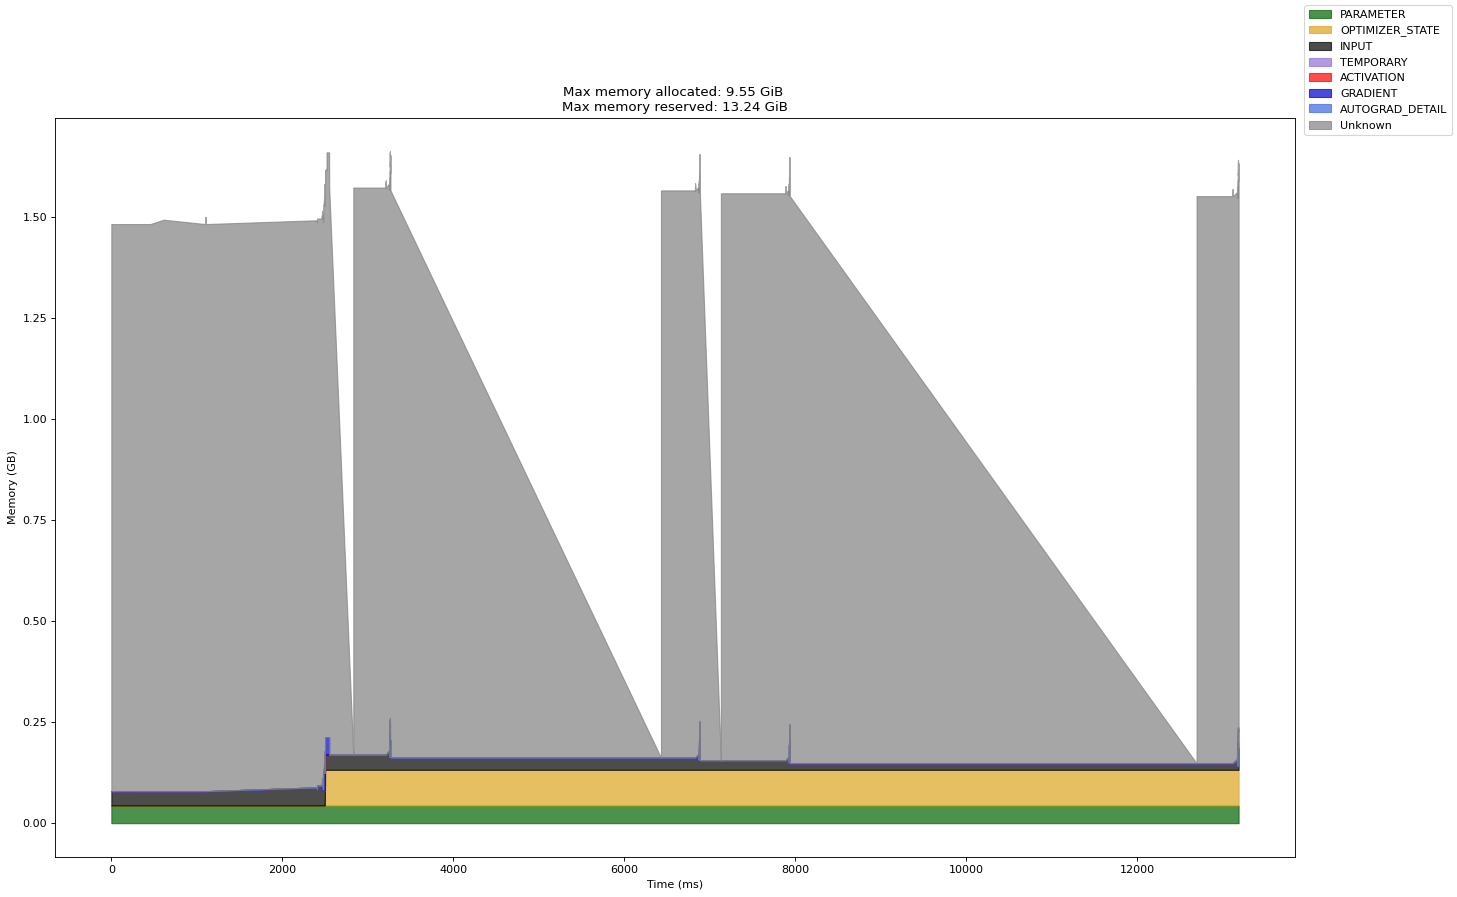

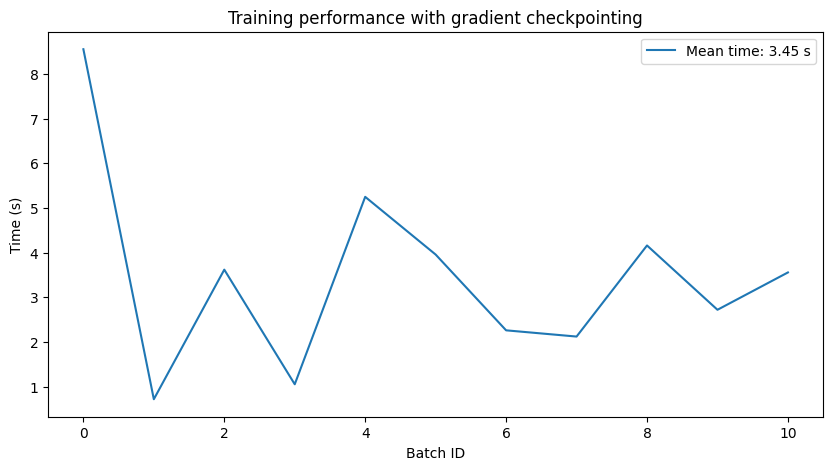

Processed for batch size 2500
Allocated memory: 16.25 MB
Cached memory: 3850.00 MB


In [7]:
num_workers = 2
break_after_num_batches = 10
batch_sizes = [2500]
fit_helper(
    model_type="resnet18_with_checkpointing", 
    dataset=tiny_imagenet_torch, 
    epochs=1, 
    break_after_num_batches=break_after_num_batches, 
    num_workers=num_workers, 
    batch_sizes=batch_sizes,
    title="with_checkpointing_2_gpus"
)


## 7. Conclusions
- Checkpointing can help fit larger batch sizes with limited GPU memory.
- This notebook explores how it impacts time and memory usage.